docker run -it --rm --runtime=nvidia -p 8888:8888 tensorflow/tensorflow:latest-gpu-jupyter

https://docs.arduino.cc/tutorials/nano-33-ble-sense-rev2/get-started-with-machine-learning/

https://github.com/tensorflow/tflite-micro-arduino-examples
 

In [15]:
import matplotlib.pyplot as plt
import pandas as pd

from spice_net import SpiceNet
from spice_net import SpiceNetHcm
from spice_net import SpiceNetSom
from spice_net.learning_rate_functions import ExpEDecayLRF, LinearLRF, ConstLRF
from spice_net.plotting import *

In [16]:
som_neuron_count = 30
df = pd.read_csv('data/test_data.csv')
df

init    result
0    -0.868245 -0.654525
1     0.866917  0.651528
2    -0.102037 -0.001062
3     0.602888  0.219135
4     0.838314  0.589141
...        ...       ...
2995 -0.181318 -0.005961
2996  0.314093  0.030987
2997 -0.313361 -0.030771
2998  0.144365  0.003009
2999  0.125558  0.001979

[3000 rows x 2 columns]

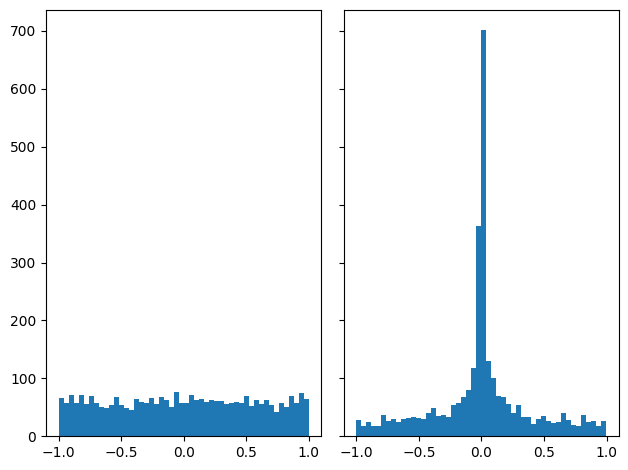

In [17]:
n_bins = 50

_, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)

# We can set the number of bins with the *bins* keyword argument.
axs[0].hist(df['init'], bins=n_bins)
axs[1].hist(df['result'], bins=n_bins)

plt.show()

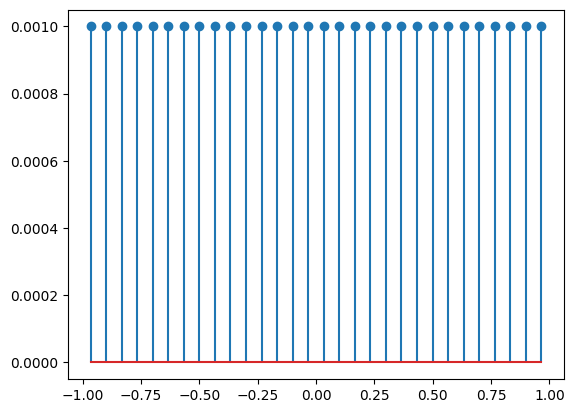

In [18]:
# tuning_curve_lrf = ExpEDecayLRF(0.001, 0.0)
tuning_curve_lrf = LinearLRF(-0.000001, 0.07)
#interaction_kernel_lrf = ExpEDecayLRF(0.001, 0.0, 1.5)
interaction_kernel_lrf = LinearLRF(1 / (len(df) * 2), 0.5)

som_result = SpiceNetSom(som_neuron_count,
                         df['init'].min(),
                         df['init'].max(),
                         tuning_curve_lrf,
                         interaction_kernel_lrf)
plot_som_weights_stem(som_result)

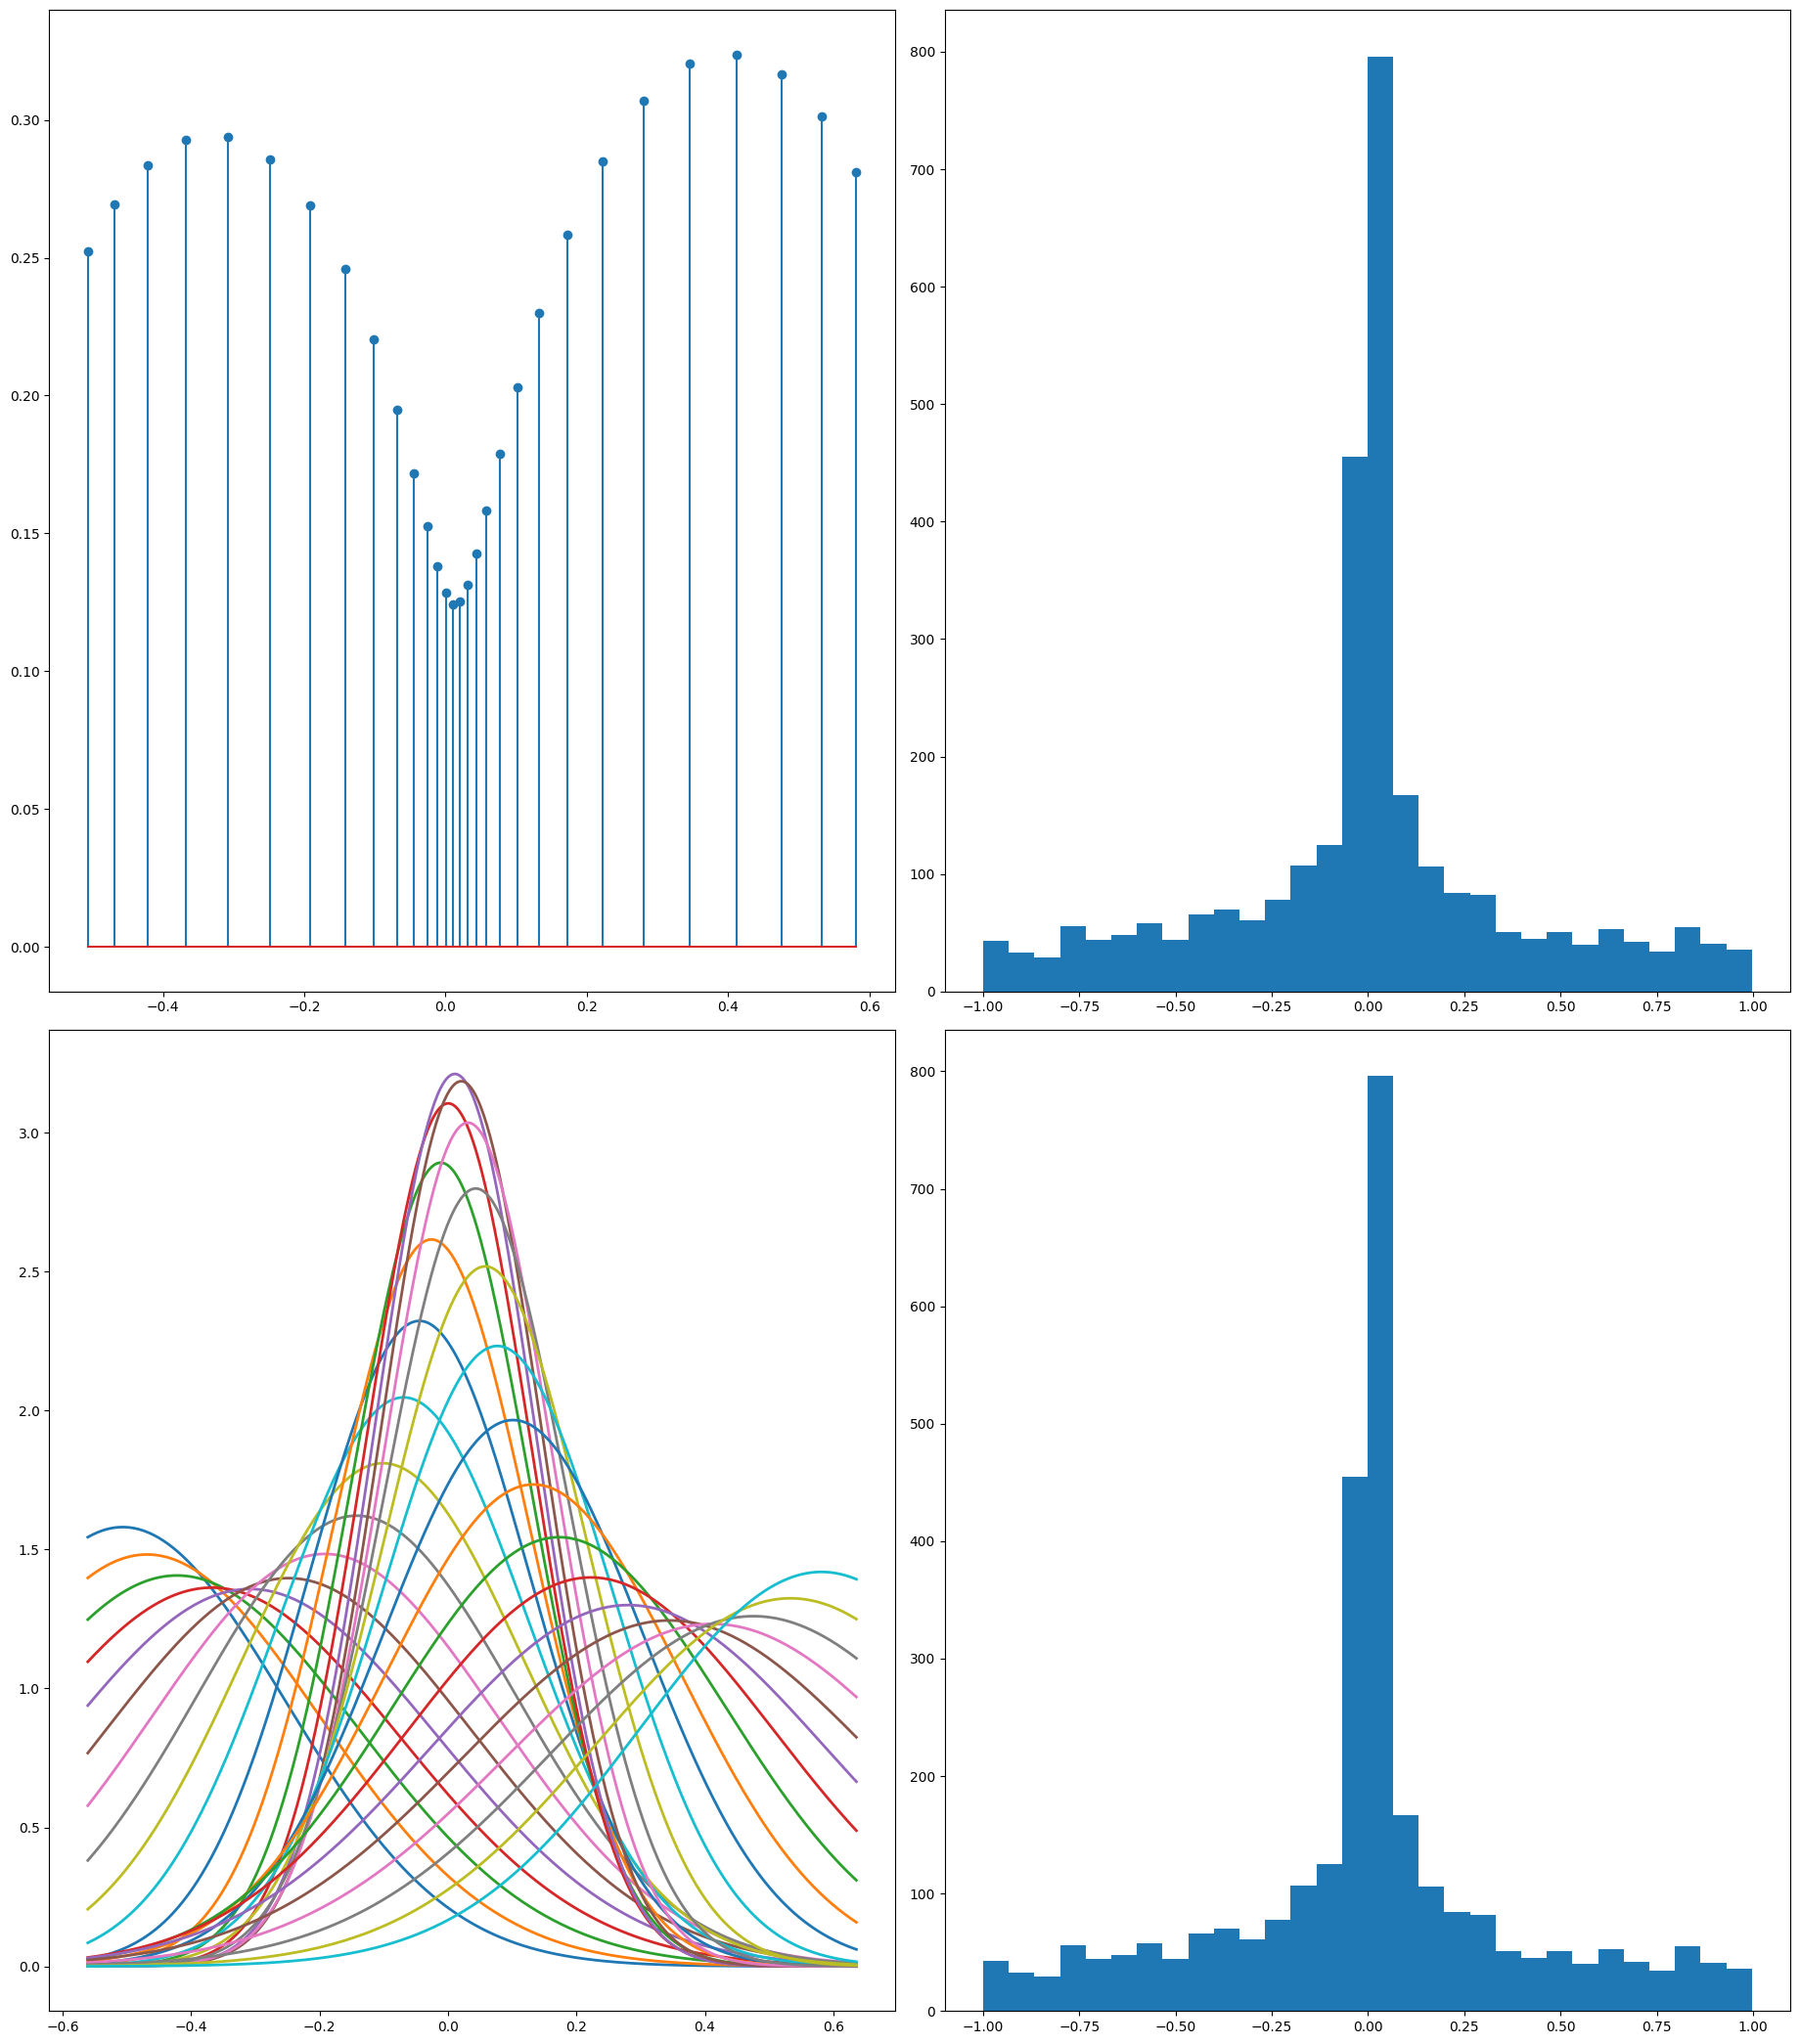

In [19]:
som_result.fit(df['result'], 10)
plot_som_comparison_to_data(som_result, df['result'].tolist())

In [20]:
plot_som(som_result)

In [21]:
som_init = SpiceNetSom(som_neuron_count,
                       df['init'].min(),
                       df['init'].max(),
                       tuning_curve_lrf,
                       interaction_kernel_lrf)
som_init.fit(df['init'].tolist(), 10)
plot_som(som_init)

In [22]:
lrf_weights = ConstLRF(0.0003)
lrf_trust_of_new = ConstLRF(0.0003)
hebbian_correlation_matrix = SpiceNetHcm(som_result,
                                         som_init,
                                         lrf_weights=lrf_weights,
                                         lrf_trust_of_new=lrf_trust_of_new)
# TODO: Why the hell did this work at all?
hebbian_correlation_matrix.fit(df['result'].tolist(),
                               df['init'].tolist(),
                               10)

plot_hcm(hebbian_correlation_matrix)

In [23]:
#tuning_curve_lrf = LinearLRF(slope=(len(df) / 2 - 1) / len(df), bias=len(df) / 2)
#interaction_kernel_lrf = ConstLRF(0.0003)

test_som_1 = SpiceNetSom(n_neurons=30,
                         value_range_start=df['init'].min(),
                         value_range_end=df['init'].max(),
                         lrf_tuning_curve=tuning_curve_lrf,
                         lrf_interaction_kernel=interaction_kernel_lrf)
test_som_2 = SpiceNetSom(n_neurons=30,
                         value_range_start=df['result'].min(),
                         value_range_end=df['result'].max(),
                         lrf_tuning_curve=tuning_curve_lrf,
                         lrf_interaction_kernel=interaction_kernel_lrf)

lrf_weights = ExpEDecayLRF(0.0001, 0.0001)
lrf_trust_of_new = ExpEDecayLRF(0.0001, 0.0001)
#lrf_weights = ConstLRF(0.0003)
#lrf_trust_of_new = ConstLRF(0.0003)

correlation_matrix = SpiceNetHcm(test_som_1,
                                 test_som_2,
                                 lrf_weights=lrf_weights,
                                 lrf_trust_of_new=lrf_trust_of_new)

spice_net = SpiceNet(correlation_matrix)
spice_net.fit(values_som_1=df['init'].tolist(),
              values_som_2=df['result'].tolist(),
              epochs_on_batch=10,
              batch_size=None,
              print_output=True)


100%|██████████| 1/1 [00:09<00:00,  9.54s/it]

Time spend on the Components: 
Som: 4.910004615783691 s | Convolution Matrix: 4.627025127410889 s


In [24]:
plot_hcm(spice_net.get_correlation_matrix())

plot_som(spice_net.get_som_1(), True)
plot_som(spice_net.get_som_2(), True)

In [25]:
sample = df.sample(1)

print(f'Predicted: {spice_net.decode_som_1(float(sample['init']))} Actual: {float(sample['result'])}')

Predicted: -0.3029523220290138 Actual: -0.0392456205543644


C:\Users\Fabi\AppData\Local\Temp\ipykernel_14784\1604558486.py:3: FutureWarning:

Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead

